loading data from /Users/tempflip/Desktop/rec2/
(24314, 7)
(3045, 7)


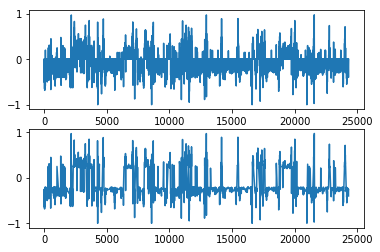

In [10]:
onServer = False

MIN_STEERING = 0.20
L_R_STEERING_ADJUST = 0.2

import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

HOME_ROOT = '/Users/tempflip/Desktop/'
SERVER_ROOT = '/home/carnd/'


#SERVER_LOG_DIR = '/home/carnd/track2/'
#SERVER_LOG_DIR2 = '/home/carnd/rec2/'

SERVER_LOG_DIR = '/Users/tempflip/Desktop/track2/'
SERVER_LOG_DIR2 = '/Users/tempflip/Desktop/rec2/'


LOG_FILE  = 'driving_log.csv'

#if onServer : dr = SERVER_LOG_DIR
#else : dr = LOG_DIR

row_list = []
def add_rows_to_rowlist(row_list, log_dir):
    print ('loading data from', log_dir)
    with open(log_dir + '/' + LOG_FILE, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            if(onServer == True):
                row[0] = row[0].replace(HOME_ROOT, SERVER_ROOT)
                row[1] = row[1].replace(HOME_ROOT, SERVER_ROOT)
                row[2] = row[2].replace(HOME_ROOT, SERVER_ROOT)
            row_list.append(row)
    return row_list

#row_list = add_rows_to_rowlist(row_list, SERVER_LOG_DIR)
row_list = add_rows_to_rowlist(row_list, SERVER_LOG_DIR2)

log = []    
log = pd.DataFrame([row for row in row_list], columns=['CENTER', 
                                                         'LEFT',
                                                         'RIGHT',
                                                         'STEERING',
                                                         'THROTTLE',
                                                         'BRAKE',
                                                         'SPEED'
                                                        ])

log['STEERING'] = pd.to_numeric(log['STEERING'])

plt.subplot(2,1,1)
plt.plot(log['STEERING'])

print (log.values.shape)

clean_log = log[log['STEERING'].abs() > MIN_STEERING]


plt.subplot(2,1,2)
plt.plot(clean_log['STEERING'])


log = clean_log
print (log.values.shape)

#log['STEERING'] *= STEERING_ADJUST


In [11]:
print(log.iloc[3000])


CENTER      /Users/tempflip/Desktop/rec2/IMG/center_2017_0...
LEFT        /Users/tempflip/Desktop/rec2/IMG/left_2017_03_...
RIGHT       /Users/tempflip/Desktop/rec2/IMG/right_2017_03...
STEERING                                              0.29421
THROTTLE                                            0.2048489
BRAKE                                                       0
SPEED                                                22.33322
Name: 24039, dtype: object


In [12]:
from scipy import misc
im_list = []
steering_targets = []

data_list = []

item_num = len(log['CENTER'].values)
#item_num = 2000

for i in range(item_num):
    c, l, r = log[['CENTER', 'LEFT', 'RIGHT']].values[i]  
    data_list.append((c, log['STEERING'].values[i]))

    #data_list.append((l, log['STEERING'].values[i] + L_R_STEERING_ADJUST))

    #data_list.append((r, log['STEERING'].values[i] - L_R_STEERING_ADJUST))
        
    # center camera
    #im = misc.imread(c)
    #im_list.append(im)
    #steering_targets.append(log['STEERING'].values[i])

    
    # left camera
    #im = misc.imread(l) 
    #im_list.append(im)
    #steering_targets.append(float(log['STEERING'].values[i]) + STEERING_ADJUST)    
    # right camera
    # left camera
    #im = misc.imread(r) 
    #im_list.append(im)
    #steering_targets.append(float(log['STEERING'].values[i]) - STEERING_ADJUST)  
    
#im_list = np.array(im_list, dtype=np.float32)
#steering_targets = np.array(steering_targets, dtype=np.float32)

#assert(steering_targets.shape[0] == im_list.shape[0])

print (len(data_list), 'points')



3045 points


In [13]:
print (data_list[0])
print (data_list[1])
print (data_list[2])

('/Users/tempflip/Desktop/rec2/IMG/center_2017_03_13_05_31_39_869.jpg', -0.34999999999999998)
('/Users/tempflip/Desktop/rec2/IMG/center_2017_03_13_05_31_39_937.jpg', -0.33148470000000002)
('/Users/tempflip/Desktop/rec2/IMG/center_2017_03_13_05_31_40_497.jpg', -0.25)


In [14]:
from sklearn.utils import shuffle
# the generator
def generator(point_list, batch_size=100):  
    batch_size = int(batch_size / 2) # we are returning 2 images for one (flipped)
    while 1:
        point_list = shuffle(point_list)
        X, Y = [], []
        
        for i in range(batch_size):
            path, angle = point_list[i]
            angle = float(angle)
            im = misc.imread(path)
                        
            X.append(im)
            Y.append(angle)
            
            # the flipped image
            X.append(np.fliplr(im))
            Y.append(angle * -1)
            
        yield np.array(X, dtype=np.float32), np.array(Y)



In [161]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K

def crop(d):
    return d[:,80:120,:,:]
    #return d[:,60:120,:,:]

def normalize(d):
    return d / 255 - 0.5

def reduce_palette(d):
    import tensorflow as tf 
    n = 40
    #n = 2
    return tf.ceil((d/n)*n)

def greyscale(d):
    import tensorflow as tf 
    r, g, b = tf.split(d, num_or_size_splits=3, axis=3)
    return (r + g + b) / 3

model = Sequential()

model.add(Lambda(reduce_palette, input_shape=(160, 320, 3)))
#model.add(Lambda(greyscale))
model.add(Lambda(normalize))
model.add(Lambda(crop))


model.add(Convolution2D(9,3,3, border_mode="same", name="conv1"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1)) #!!!!!!!!!
model.add(Activation('relu', name="relu1"))

model.add(Convolution2D(18,3,3, border_mode="same", name="conv2"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1)) #!!!!!!!!!!
model.add(Activation('relu', name="relu2"))


model.add(Flatten())

model.add(Dense(10))
model.add(Dense(1))

#print(model.inputs)
print(model.outputs)




[<tf.Tensor 'add_384:0' shape=(?, 1) dtype=float32>]


0.3204308


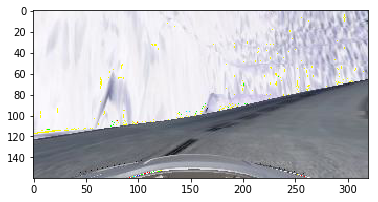

In [162]:
# some filter tests
g = generator(data_list, batch_size=20)
img, angle = next(g)
print (angle[0])

plt.imshow(img[0])

In [163]:
gen = generator(data_list, batch_size=500)
val_gen = generator(data_list, batch_size=100)

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit_generator(gen, samples_per_epoch = 10000, nb_epoch=10, validation_data=val_gen, nb_val_samples=100)


Epoch 1/10
10000/10000 [==============================] - 12s - loss: 0.3980 - acc: 0.0203 - val_loss: 0.2170 - val_acc: 0.0000e+00

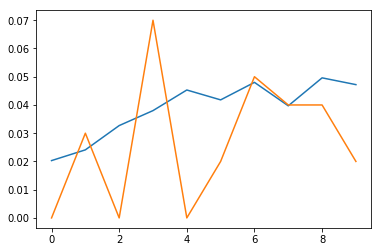

In [164]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [165]:
model.save('/home/carnd/mod.h5')
#model.save('./my_model.h5')
print("Saved.")

Saved.


In [113]:
from keras.models import load_model
from keras import backend as K
#from keras.utils.visualize_util import plot

m = load_model('./mod.h5')
m.load_weights('./mod.h5')
#plot(m, to_file='model.png')


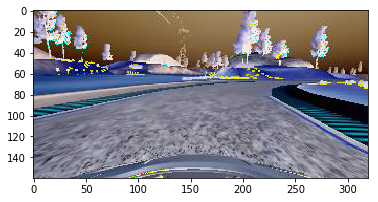

In [114]:
g = generator(data_list, batch_size=10)
_img, angle = next(g)
img = _img[0]
plt.imshow(img)

In [115]:
#m.layers = m.layers[0:3]
print (m.layers)
print (m.summary())



[<keras.layers.core.Lambda object at 0x12b0d92e8>, <keras.layers.core.Lambda object at 0x12b0d9710>, <keras.layers.core.Lambda object at 0x12b11a080>, <keras.layers.convolutional.Convolution2D object at 0x12b430cc0>, <keras.layers.pooling.MaxPooling2D object at 0x12b44eba8>, <keras.layers.core.Dropout object at 0x12b150dd8>, <keras.layers.core.Activation object at 0x12b459e80>, <keras.layers.convolutional.Convolution2D object at 0x12b37de48>, <keras.layers.pooling.MaxPooling2D object at 0x12b499978>, <keras.layers.core.Dropout object at 0x12b533be0>, <keras.layers.core.Activation object at 0x12b533c88>, <keras.layers.core.Flatten object at 0x12eb9fd30>, <keras.layers.core.Dense object at 0x12b547550>, <keras.layers.core.Dense object at 0x12b595470>]
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_43 (Lambda)               (None

In [291]:
from keras.models import Model


layer_dict = dict([(l.name, l) for l in m.layers] )
print (layer_dict.keys())

int_model = Model(input = m.input, output = layer_dict['conv1'].output)

_pr = int_model.predict(_img)
print (_pr.shape)

#x = np.ceil(np.random.rand(1, 160, 320, 3) * 255)
#pr =  int_model.predict(x)

#print(pr.shape)
#im = pr[5].reshape(90, 160)
#plt.imshow(im)

#plt.imshow(pr[0,:,:,19])

#w, b = layer_dict['conv1'].get_weights()

#print (w.shape, b.shape)
#plt.imshow(w[:,:,:,4])
#output = m.predict(_img)
#print(output)

dict_keys(['relu1', 'dense_29', 'flatten_15', 'relu2', 'dense_30', 'lambda_44', 'conv2', 'maxpooling2d_30', 'dropout_29', 'conv1', 'dropout_30', 'lambda_45', 'lambda_43', 'maxpooling2d_29'])
(10, 40, 320, 9)


In [333]:
input_img = np.random.rand(1,40,320,9)
print('min, max', np.min(input_img), np.max(input_img))


X = K.placeholder(ndim=4) #specify the right placeholder
X = layer_dict['conv1'].output

loss = K.sum(K.square(X)) # loss function
grads = K.gradients(loss, [X])

print(loss)
print(grads)
fn = K.function([X], [loss,grads[0]]) #function to call the gradient

l, g = fn([input_img])

step = 10

for i in range(10):
    l, g = fn([input_img])
    input_img -= g / step
    print(l)

print('min, max', np.min(input_img), np.max(input_img))




min, max 2.85220409045e-05 0.999995676409
Tensor("Sum_79:0", shape=(), dtype=float32)
[<tf.Tensor 'gradients_93/Square_130_grad/mul_1:0' shape=(?, 40, 320, 9) dtype=float32>]
38240.8
24474.2
15663.5
10024.6
6415.76
4106.08
2627.89
1681.85
1076.39
688.887
min, max 3.06253082039e-06 0.107373719643


0.0 6912.0


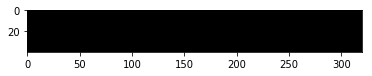

In [336]:
#input_img = np.floor(input_img * np.max(input_img))
print(np.min(input_img), np.max(input_img))

plt.imshow(input_img[0,:,:,3:6])